<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned
on another dataset and applying them to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


Importing the code we've written in previous sections so that we don't have to write it all again.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.39 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostice code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Sun May 26 02:35:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on.

In [5]:
import os
import zipfile
import requests

def _download_from_github(path: str, url: str) -> None:
    # Download pizza, steak, sushi data
    with open(path, "wb") as f:
        request = requests.get(url)
        print("Downloading data from github...")
        f.write(request.content)

def _unzip_file(zip_path: str, extract_to: str) -> None:
    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Unzipping data...{zip_path}")
        zip_ref.extractall(extract_to)

def _make_data_dir(path: str) -> None:
    # If the image folder doesn't exist, create it
    if os.path.isdir(path):
        print(f"{path} directory exists, skipping re-download.")
    else:
        print(f"Did not find {path}, creating it...")
        os.makedirs(path, exist_ok=True)

def download_data(url: str, to_path: str = 'data', to_image_path: str = 'pizza_steak_sushi') -> None:
    # Images from a subset of classes from the Food101 dataset
    image_path = os.path.join(to_path, to_image_path)

    try:
        _make_data_dir(image_path)  # Ensure the base directory exists

        zip_file_path = os.path.join(image_path, 'pizza_steak_sushi.zip')

        # Download from github
        _download_from_github(zip_file_path, url)

        # Unzip
        _unzip_file(zip_file_path, image_path)

        # Delete zip file
        os.remove(zip_file_path)
    except Exception as e:
        print(f"Oops...something happened: {e}")

In [6]:
download_data(url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, creating it...
Unzipping data...data/pizza_steak_sushi/pizza_steak_sushi.zip


In [7]:
# setup directory path
image_path = os.path.join('data', 'pizza_steak_sushi')

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

train_dir, test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()`
function we made in 05. PyTorch Going Modular.

In [8]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)



In [9]:
from torchvision import transforms

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # get images into range [0, 1]
    normalize #make sure images have the same distribution as ImageNet
])

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792fd298e5c0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transfomr for `torchvision.models` (auto creation)

In [11]:
# Get a set of pretrained model weights

# "DEFAULT" = best available weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792fd298dc00>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an alerady well-performing model from a problem space similar to your own and then customize to your own problem.

 Three things to consider:
 1. Speed - how fast does it run?
 2. Size - how big is the model?
 3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images?)

 Where does the model live?

 Is it on device (like a self-driving car)

 Or does it llive on a server?

 Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

 Which model should we choose?

 For our case, it looks like EffnetB0 is one of our best options in terms of performance vs size.

 However, in light of The Bitter Lesson, if we had infinite compute, we'ed likely pick the biggest model + most parameters + most general we could.

 http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EFFNetB0.
https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights



In [14]:
# Old method of creating a pretrained model
#model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 78.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [16]:
# print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freessing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [17]:
# Freeze all the base layers in EffNetB0

for param in model.features.parameters():
  param.requires_grad = False

In [18]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [19]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # prevent overfitting by randomly dropping some of th neurons
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names), bias=True).to(device)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0010)

In [22]:
# import train function
from going_modular.going_modular import engine

# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer

start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer and print out how long it took
end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 21.127 seconds


## 5. Evaluate model by plotting loss curves

In [23]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

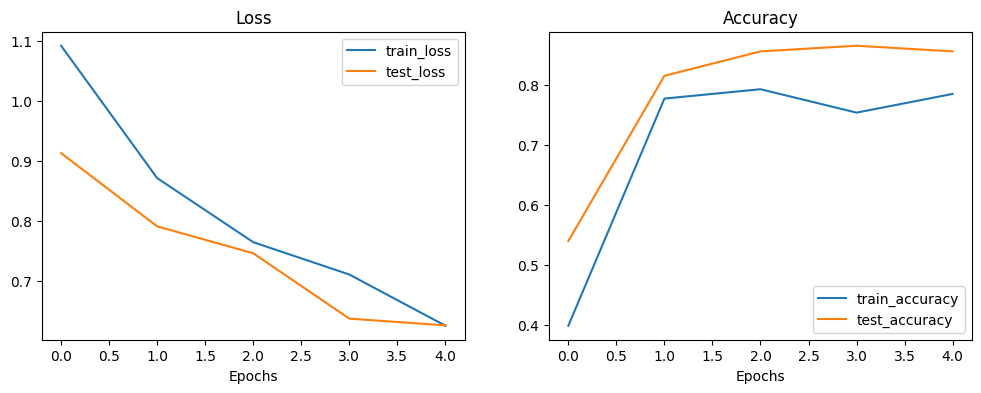

In [24]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer;s motto of * visualize, visualize, visualize*!

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be the same shape as the model was trained on.
* Same datatype - custom data should be in the same data type
* Same device - custom data/test should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image()`

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this relates to batch size)
7. Make a prediction on the image by passing it to the model
8. Convert the model's output logits to the prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8


In [40]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module, class_names: List[str], img_pth: str,
                        transform: torchvision.transforms = None, img_size: Tuple[int, int] = (224, 224), device: torch.device = device) -> None:

  # get image
  img = Image.open(img_pth)

  # create transform is neened
  img_transform = transform if transform is not None else transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      # scaling the input tenso to have a mean of 0 and std of 1 to speed up training process and better convergence.
      # we want our images to have the same distribution at ImageNet since we are going to use a model trained on those images
      # for transfer learning.
      transforms.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
  ])

  ### Predict on image ###
  # make sure model is on the target device
  model.to(device)

  # prepare model for testing, eval and inference mode
  model.eval()

  with torch.inference_mode():
    # transform image and add an extra batch dimension
    transformed_img = img_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # make a prediction on the transformed image
    target_img_pred = model(transformed_img.to(device))

  # convert output logits to pred probs
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)

  # convert pred_probs to pred_labels
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

  # plot image with predicted label and prob
  plt.figure(figsize=(4, 4))
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_img_pred_label]} | Prob: {(target_img_pred_probs.max() * 100):.3f}%")
  plt.axis(False)

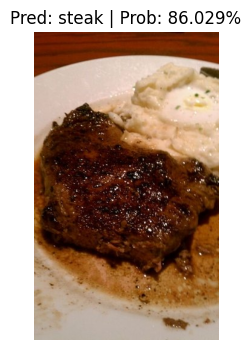

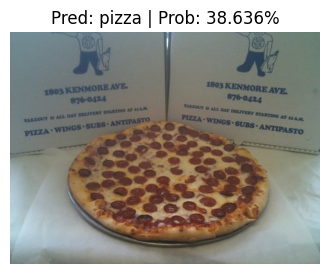

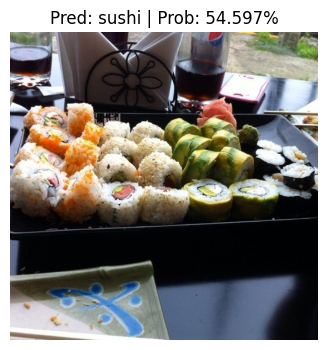

In [44]:
import random
from pathlib import Path

img_pth = Path("data/pizza_steak_sushi/test")
img_pth_list = list(img_pth.glob("*/*.jpg"))

for _ in range(3):
  rand_img_pth = random.choice(img_pth_list)
  pred_and_plot_image(model, class_names, rand_img_pth)

data/something_i_downloaded.jpeg already exists, skipping download...


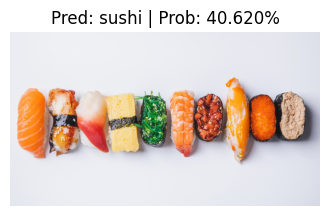

In [48]:
import requests
from pathlib import Path

custom_image_path = Path("data/something_i_downloaded.jpeg")

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/sushi.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

pred_and_plot_image(model, class_names, str(custom_image_path))
